In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data
from useful_fun import plot_distribution, percentage_outof_CI, number_outof_CI

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

2022-08-18 20:45:51.772808: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-18 20:45:52.344213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


# Simple one-latent function model

        y = f(x) + e
        f = GP(0, RBF)

2022-08-16 12:26:04.208921: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-16 12:26:09.656687: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x72bbf00


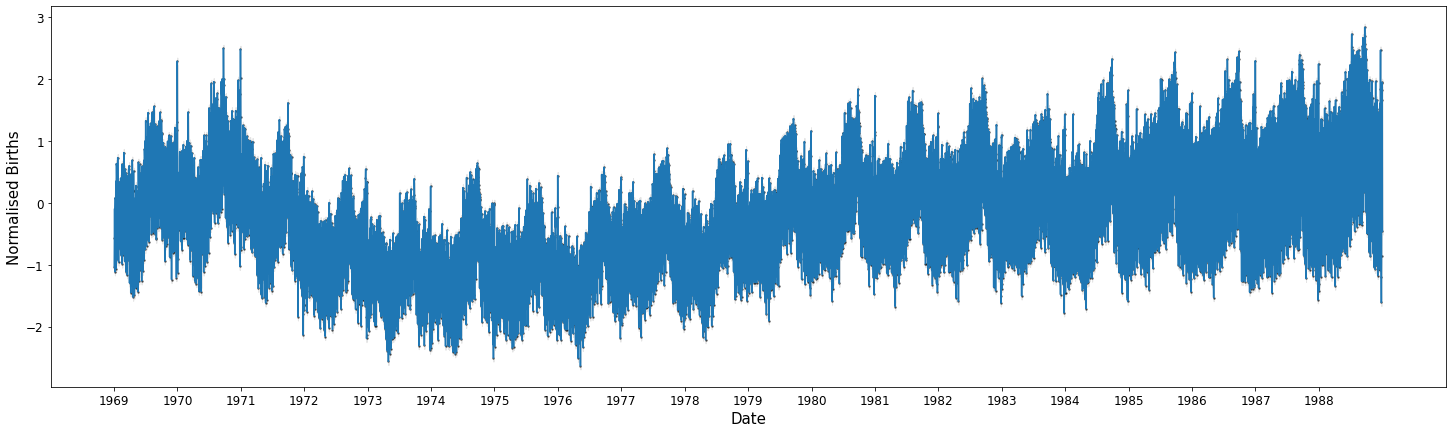

Fitted values MSE:  1.0996666091971443e-06
Log-marginal likelihood:  -7832.24926461639
Percentage of points out of CI:  0.0
number of points out of CI:  0


In [3]:
# build model & compute fitted values

kernel = gpflow.kernels.RBF()

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_y(x)

plot_distribution(x, y, mean, var, pos, labels, legend=False)

print('Fitted values MSE: ', mean_squared_error(y, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
print('Percentage of points out of CI: ',  percentage_outof_CI(y, mean, var))
print('number of points out of CI: ',  number_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

The above model uses a GP with RBF kernel. The data is normalised but we still train the noise variance. We have perfect interpolation ie the posterior variance is 0. This is not what we want.

Next we try the same model but set the noise variance to 1 and untrainable.

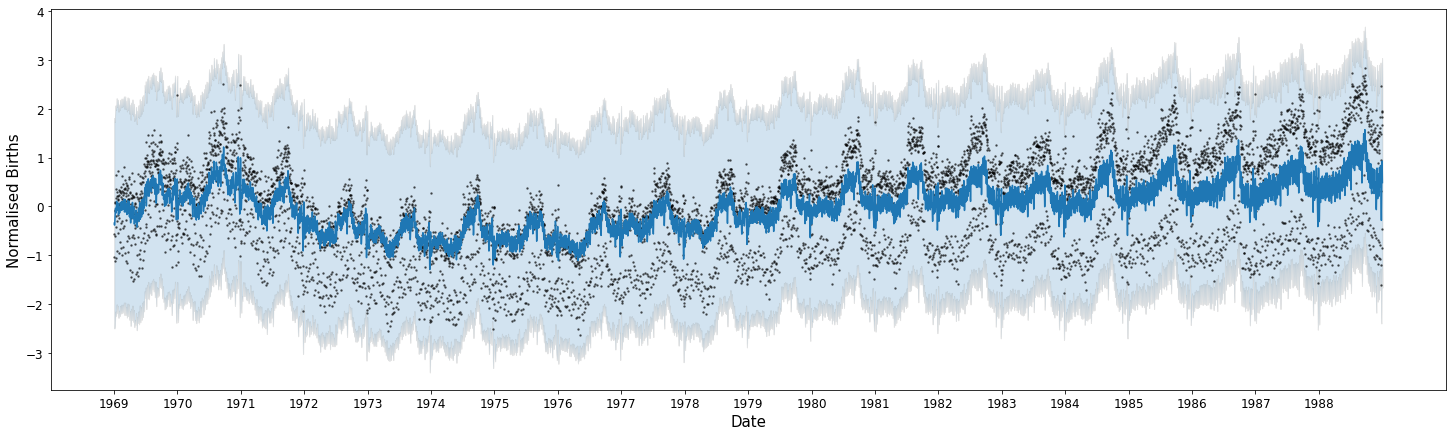

Fitted values MSE:  0.4400270434554007
Log-marginal likelihood:  -9778.918001179252
Percentage of points out of CI:  0.0
number of points out of CI:  0


In [4]:
# build model & compute fitted values

kernel = gpflow.kernels.RBF()

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_y(x)

plot_distribution(x, y, mean, var, pos, labels, legend=False)

print('Fitted values MSE: ', mean_squared_error(y, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
print('Percentage of points out of CI: ',  percentage_outof_CI(y, mean, var))
print('number of points out of CI: ',  number_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

We are not overfitting as much. The GP captures the overall trend. Possibly the long term behaviour of the data. But it remains in the middle of the two observable trends (weekend and weekday births). The CI is also not good enough(?)

Add priors to penalised small length scales. 

! First, without learning the noise variance 

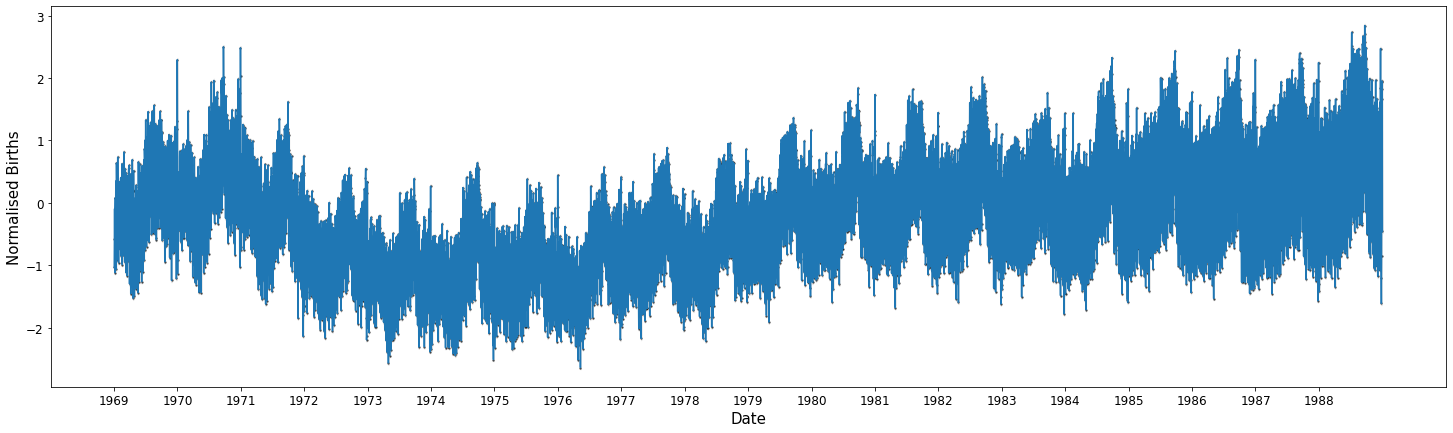

Fitted values MSE:  8.946596706316102e-08
Log-marginal likelihood:  -7832.248817539294
Percentage of points out of CI:  0.0
number of points out of CI:  0


In [5]:
# rebuild model and add prior to hyperparameters

kernel = gpflow.kernels.RBF()

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)

# adding priors
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_y(x)

plot_distribution(x, y, mean, var, pos, labels, legend=False)

print('Fitted values MSE: ', mean_squared_error(y, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
print('Percentage of points out of CI: ',  percentage_outof_CI(y, mean, var))
print('number of points out of CI: ',  number_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

Again overfitting... Because of the noise variance being trained, it is almost zero after optimisation.

Let's not train it again but still use priors to regularise the choice of hyperparmeters.

! Now, not training noise variance

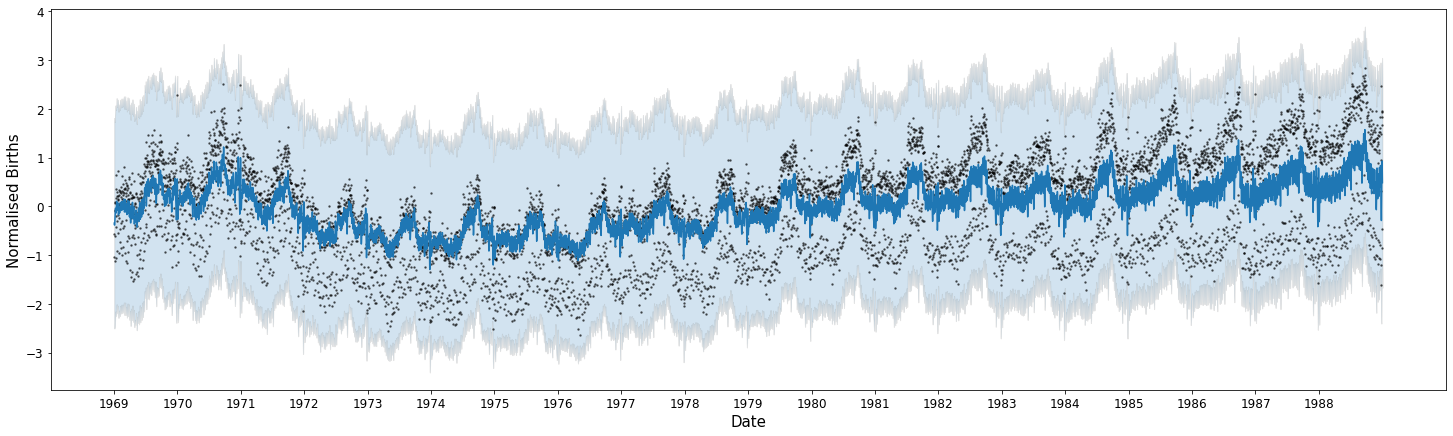

Fitted values MSE:  0.43945973104793373
Log-marginal likelihood:  -9778.91990547541
Percentage of points out of CI:  0.0
number of points out of CI:  0


In [6]:
# rebuild model with priors but don't train noise variance

kernel = gpflow.kernels.RBF()

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)

# adding priors
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)
#print('Optimisation Results: ', opt_logs)

mean, var = model.predict_y(x)

plot_distribution(x, y, mean, var, pos, labels, legend=False)

print('Fitted values MSE: ', mean_squared_error(y, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
print('Percentage of points out of CI: ',  percentage_outof_CI(y, mean, var))
print('number of points out of CI: ',  number_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

It is exactly the same as with no priors WTF !?!

Try different priors but setting the noise variance to not trainable all the time.

2022-08-16 13:02:37.954821: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-16 13:02:43.393577: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x1de4a5f0


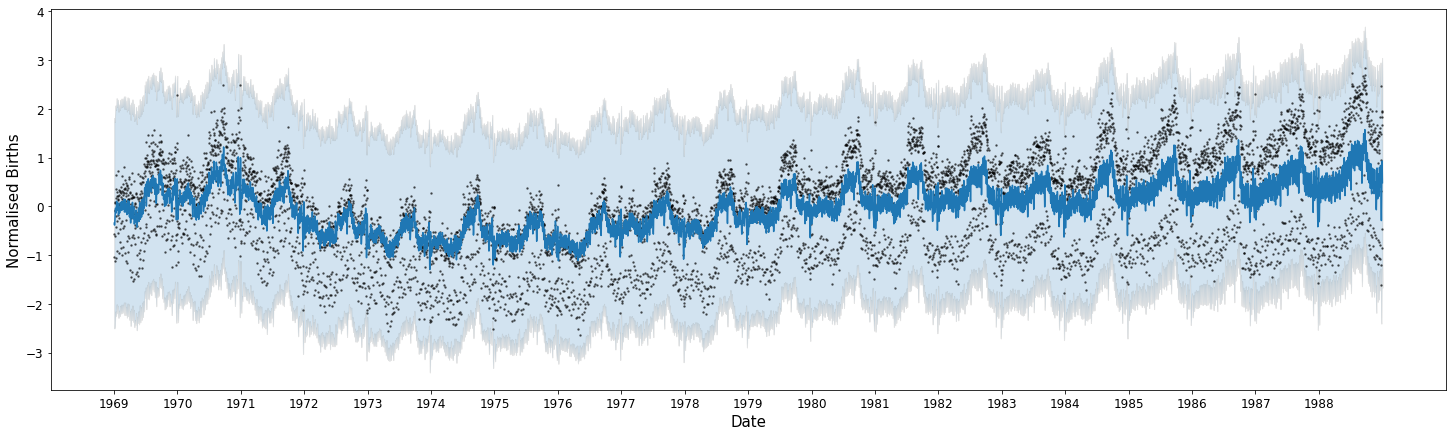

Fitted values MSE:  0.4390813492968635
Log-marginal likelihood:  -9778.922009115795
Percentage of points out of CI:  0.0
number of points out of CI:  0


In [3]:
# rebuild model with priors but don't train noise variance

kernel = gpflow.kernels.RBF()

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)

# adding priors
model.kernel.lengthscales.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_y(x)

plot_distribution(x, y, mean, var, pos, labels, legend=False)

print('Fitted values MSE: ', mean_squared_error(y, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
print('Percentage of points out of CI: ',  percentage_outof_CI(y, mean, var))
print('number of points out of CI: ',  number_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

Again, similar fitting to the data. Maybe the choice of prior doesn't make much difference.

Investigate how the hyperparameter starting point affects the fitting of the model.

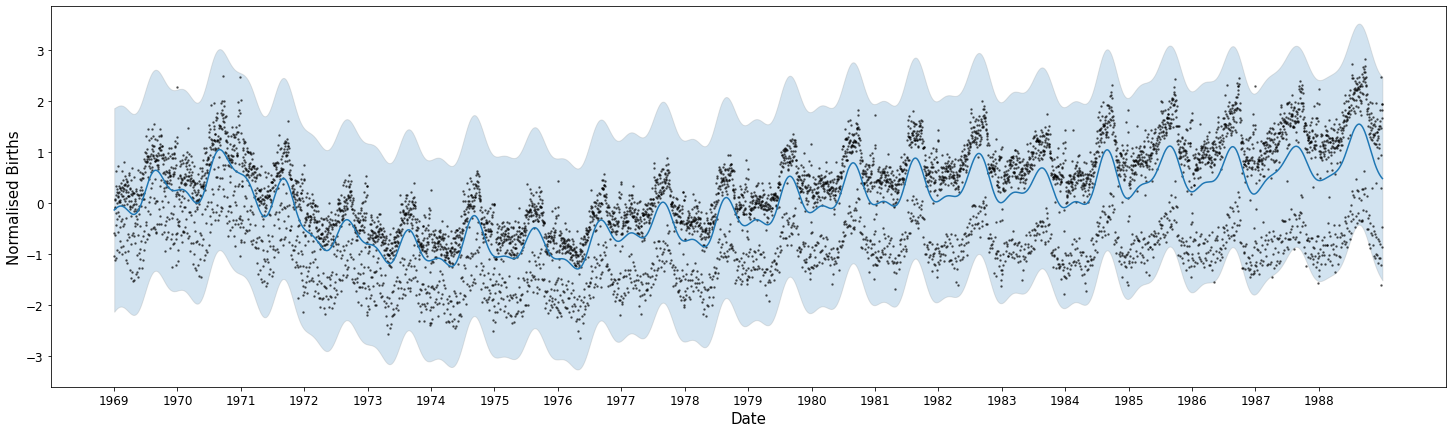

Fitted values MSE:  0.5539196737690918
Log-marginal likelihood:  -8920.487536972463
Percentage of points out of CI:  0.12320328542094457
number of points out of CI:  9


In [5]:
# without priors but different starting conditions

kernel = gpflow.kernels.RBF(lengthscales=5, variance=1)

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)

# # adding priors
# model.kernel.lengthscales.prior = tfp.distributions.Gamma(to_default_float(3), to_default_float(2))
# model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_y(x)

plot_distribution(x, y, mean, var, pos, labels, legend=False)

print('Fitted values MSE: ', mean_squared_error(y, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
print('Percentage of points out of CI: ',  percentage_outof_CI(y, mean, var))
print('number of points out of CI: ',  number_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

### Sensitivity Analysis

In [8]:
# automate the process

def optimise_predict_model(kernel):
    
    model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
    set_trainable(model.likelihood.variance , False)

    model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
    model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

    mean, var = model.predict_y(x)

    print('Fitted values MSE: ', mean_squared_error(y, mean))
    print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
    print('Percentage of points out of CI: ',  percentage_outof_CI(y, mean, var))
    print('number of points out of CI: ',  number_outof_CI(y, mean, var))

    plot_distribution(x, y, mean, var, pos, labels, legend=False)

    print_summary(model, fmt='notebook')


Starting Values (l,v):  1 1
Fitted values MSE:  0.43945973104793373
Log-marginal likelihood:  -9778.91990547541
Percentage of points out of CI:  0.0
number of points out of CI:  0


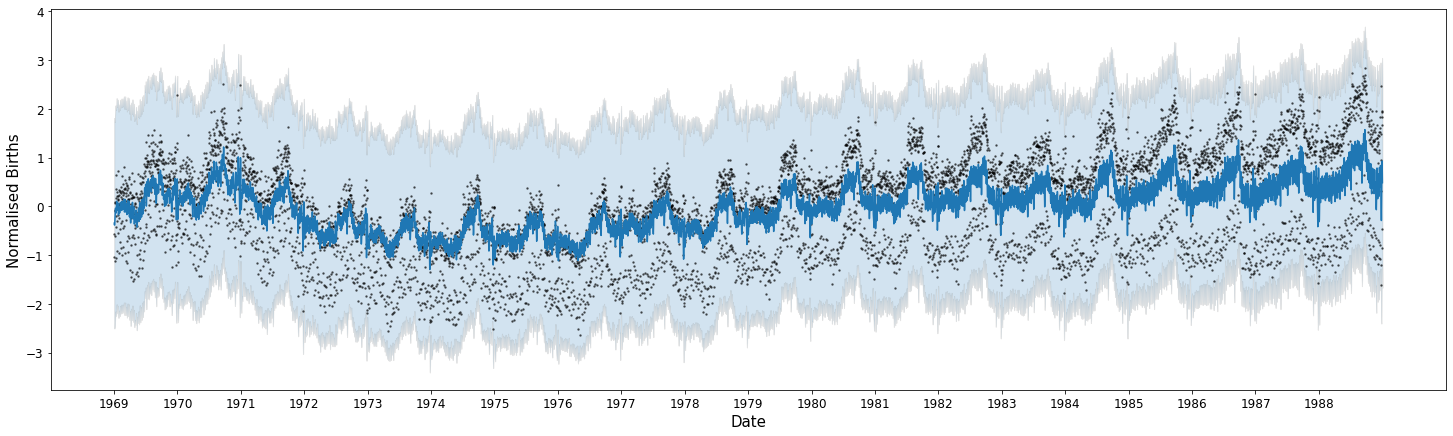

Starting Values (l,v):  1 5
Fitted values MSE:  0.553883446920947
Log-marginal likelihood:  -8920.497223268881
Percentage of points out of CI:  0.12320328542094457
number of points out of CI:  9


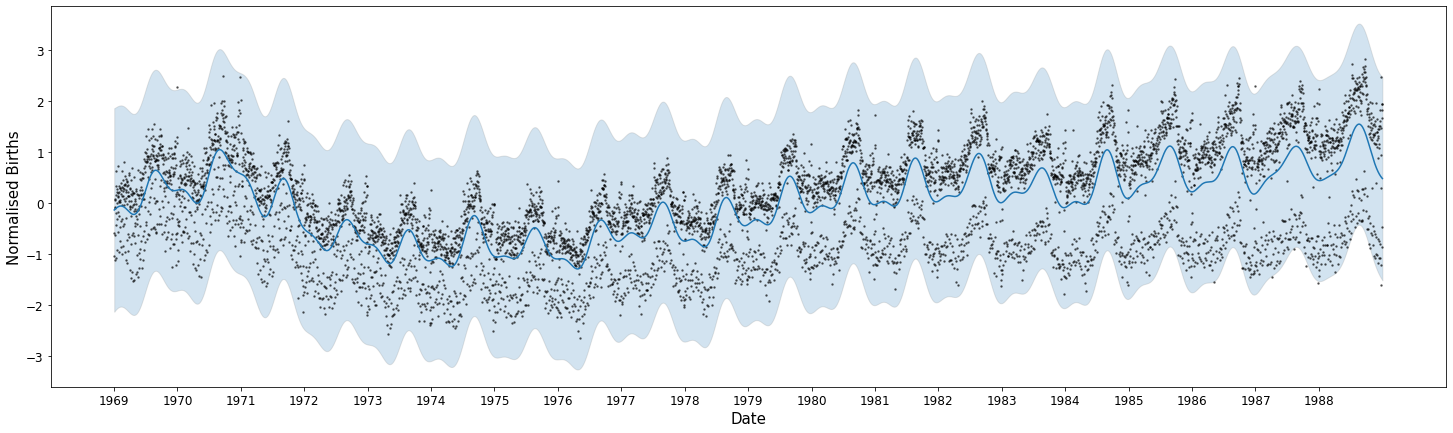

Starting Values (l,v):  5 1
Fitted values MSE:  0.5538827519733032
Log-marginal likelihood:  -8920.497194370872
Percentage of points out of CI:  0.12320328542094457
number of points out of CI:  9


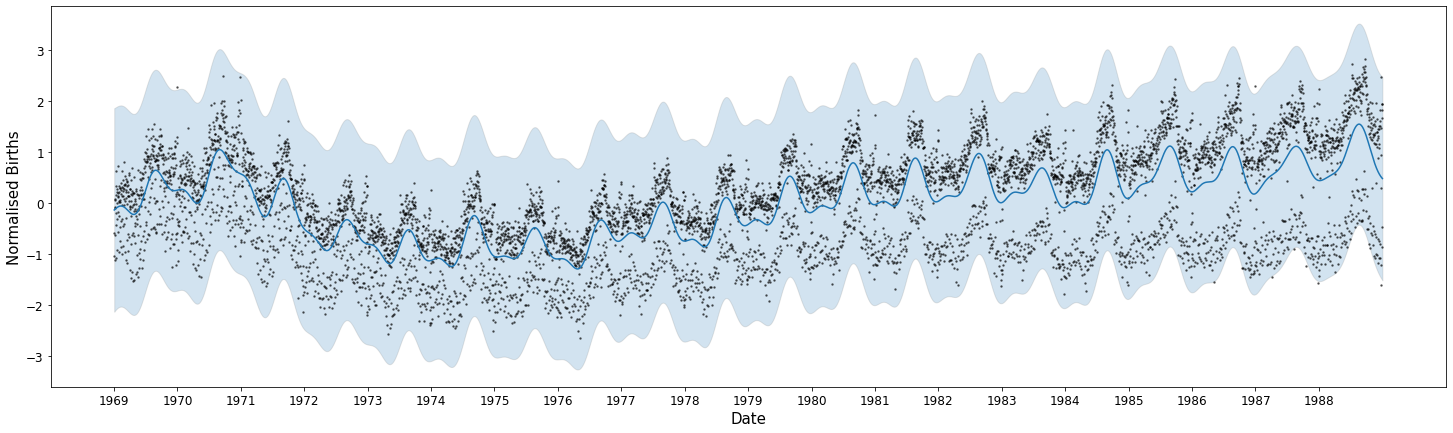

Starting Values (l,v):  5 5
Fitted values MSE:  0.5538828141139536
Log-marginal likelihood:  -8920.497181167795
Percentage of points out of CI:  0.12320328542094457
number of points out of CI:  9


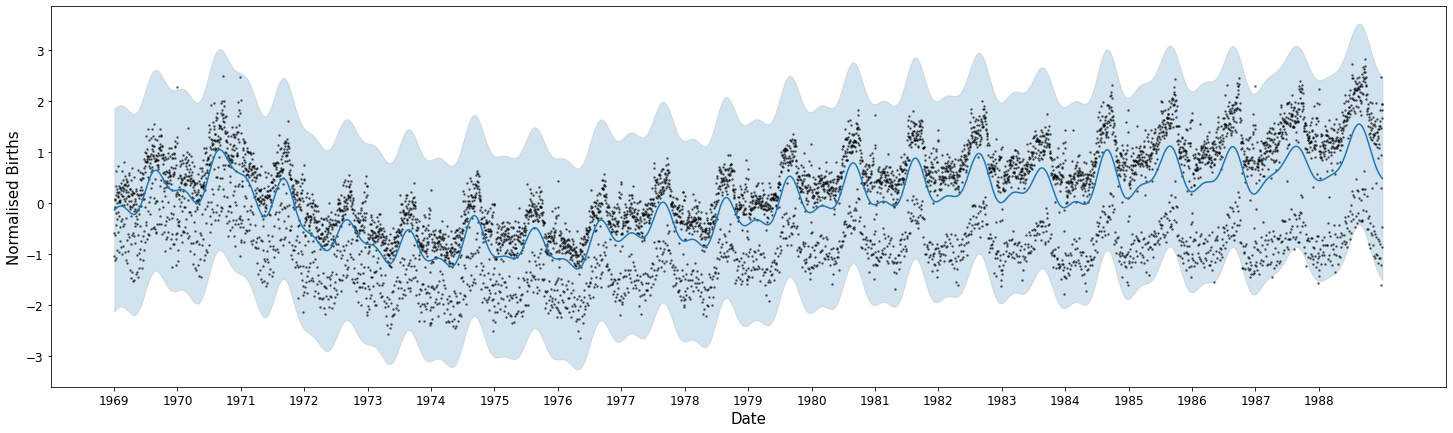

In [9]:
starting_values_l = [1, 5]
starting_values_v = [1, 5]

for l in starting_values_l:
    for v in starting_values_v:
        print('Starting Values (l,v): ', l, v)
        kernel = gpflow.kernels.RBF(lengthscales = l, variance = v)
        optimise_predict_model(kernel)


So FOR THE RBF KERNEL we have found 2 local minima: (l,v) -- (73.3, 0.37) & (2.22, 0.37)

-------------------------------------------------------------

# Train / Test split: model selection

Assess which kernel helps represent the data best.

    MSE, MAE, Likelihood

Since we have found that the starting point of kernel parameters affects the fit significantly, we will first select the kernel and then run an analysis to find optimal starting conditions for hyperparameters.

In [3]:
def optimise_predict_model(model):
    
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

    mean_train, var_train = model.predict_y(x_train)
    mean_test, var_test = model.predict_y(x_test)

    print('Train')
    plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)
    print('Test')
    plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

    print_summary(model, fmt='notebook')
    print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
    print('train MSE, MAE: ', mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
    print('test MSE, MAE: ', mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
    print('Percentage of points that lie outside the CI: (train, test) ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))
    print('number of points that lie outside the CI: (train, test) ', number_outof_CI(y_train, mean_train, var_train), number_outof_CI(y_test, mean_test, var_test))

The models consist of a single latent function, untrainable noise variance (justify), hyperparameters with priors.

Train


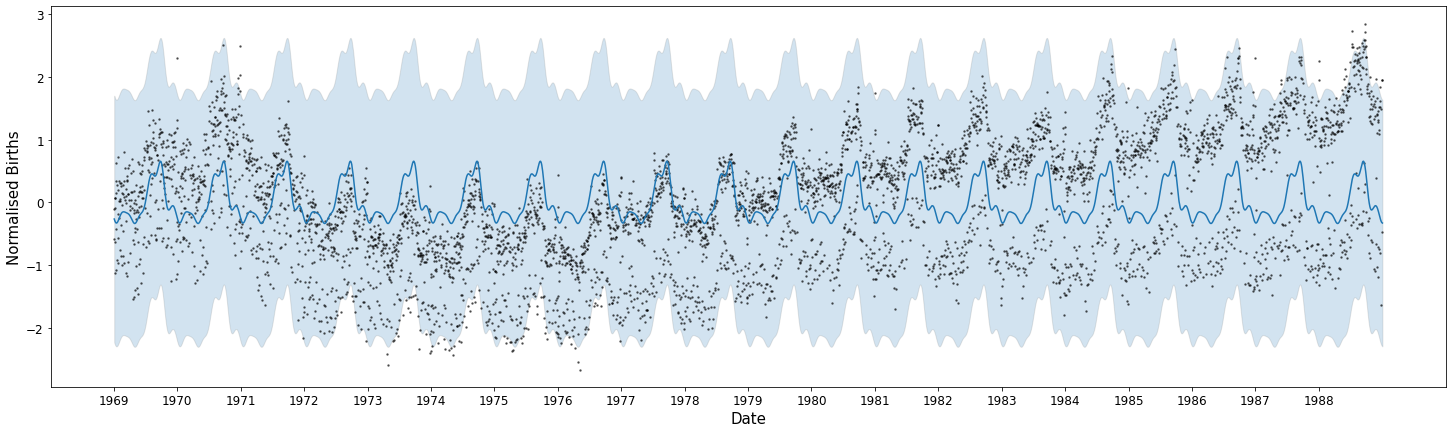

Test


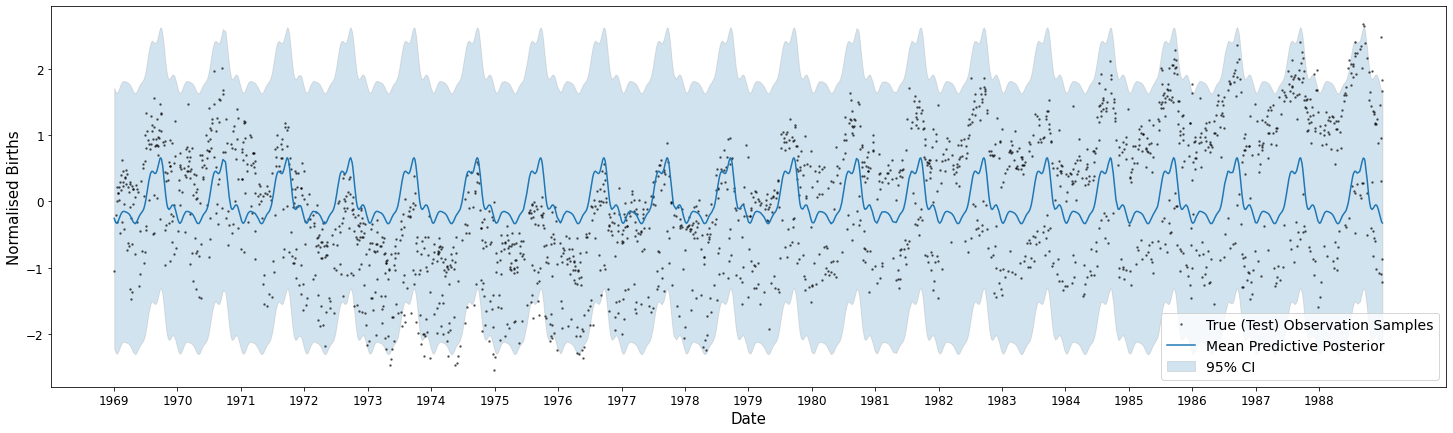

Log-marginal likelihood:  -7038.184030957546
train MSE, MAE:  0.9043421593106806 0.8129797990394488
test MSE, MAE:  0.9279961459821914 0.8284753280665085
Percentage of points that lie outside the CI: (train, test)  2.053588891061999 2.235401459854015
number of points that lie outside the CI: (train, test)  105 49
--------------------------------------------------------
Train


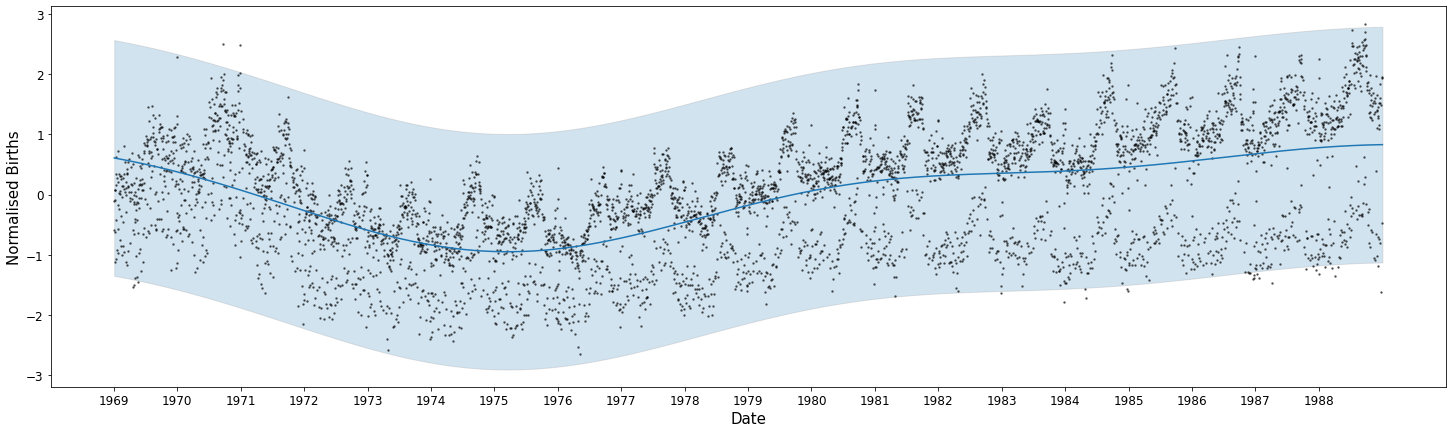

Test


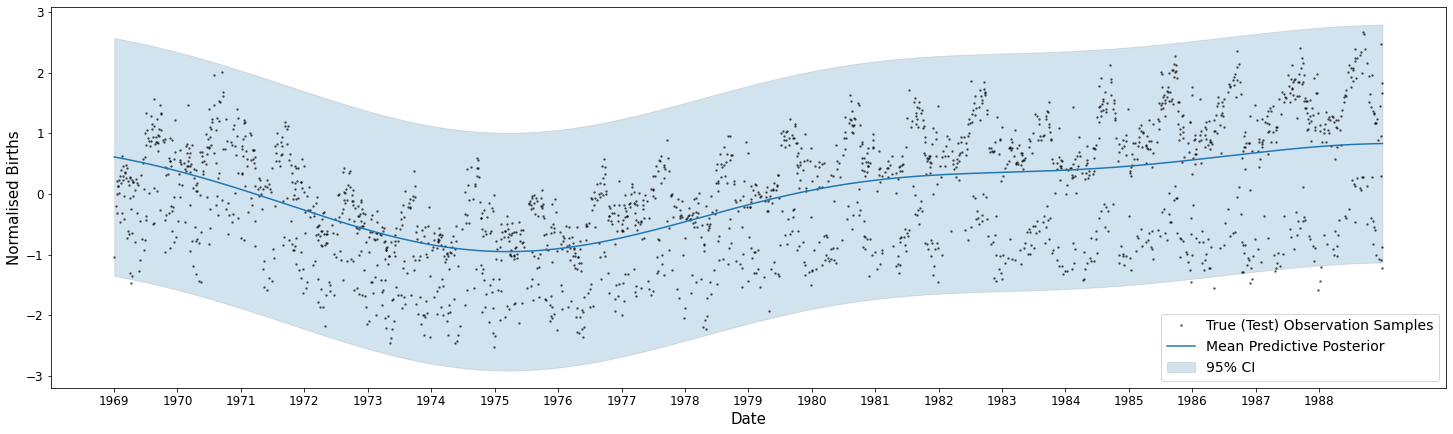

Log-marginal likelihood:  -6463.204695425724
train MSE, MAE:  0.6821788395954064 0.6704310534617993
test MSE, MAE:  0.6940576651012982 0.6802957894579178
Percentage of points that lie outside the CI: (train, test)  0.5867396831605711 0.45620437956204374
number of points that lie outside the CI: (train, test)  30 10
--------------------------------------------------------
Train


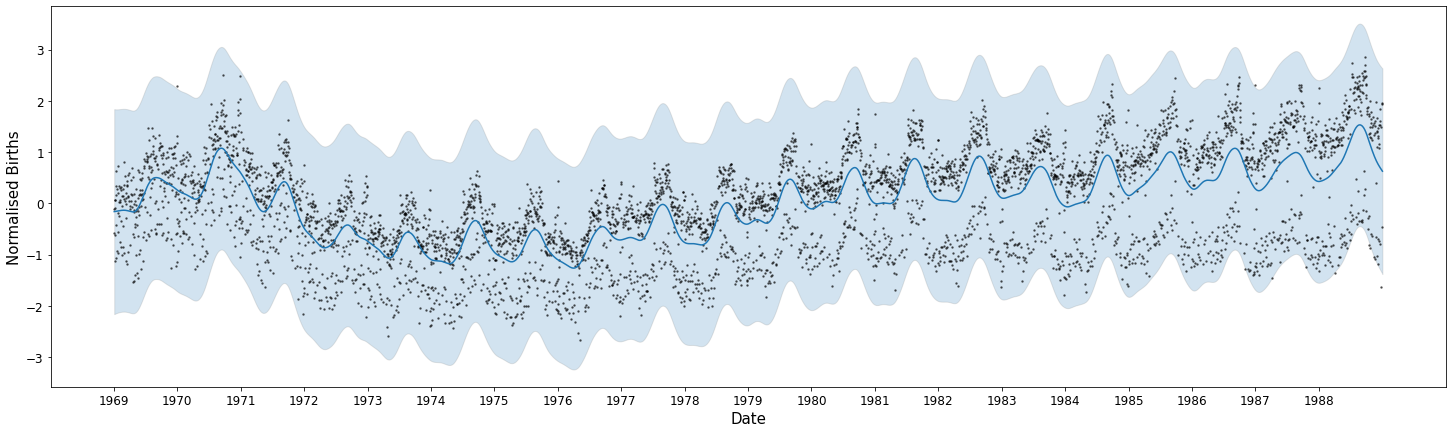

Test


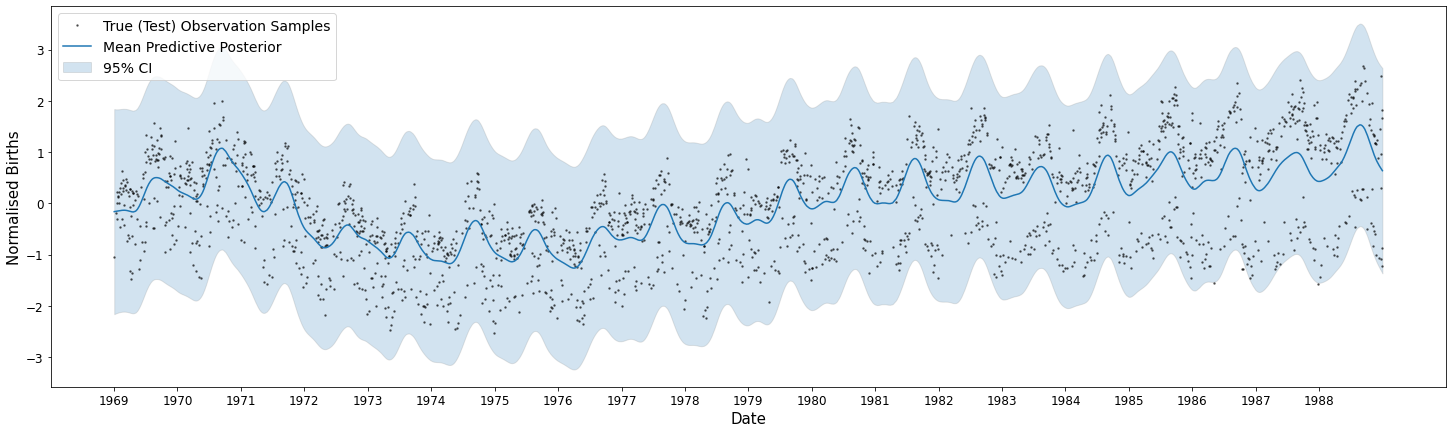

Log-marginal likelihood:  -6277.216345380468
train MSE, MAE:  0.5564763217514167 0.6275347419962262
test MSE, MAE:  0.5930466937929167 0.6478874388818548
Percentage of points that lie outside the CI: (train, test)  0.17602190494817133 0.18248175182481752
number of points that lie outside the CI: (train, test)  9 4
--------------------------------------------------------
Train


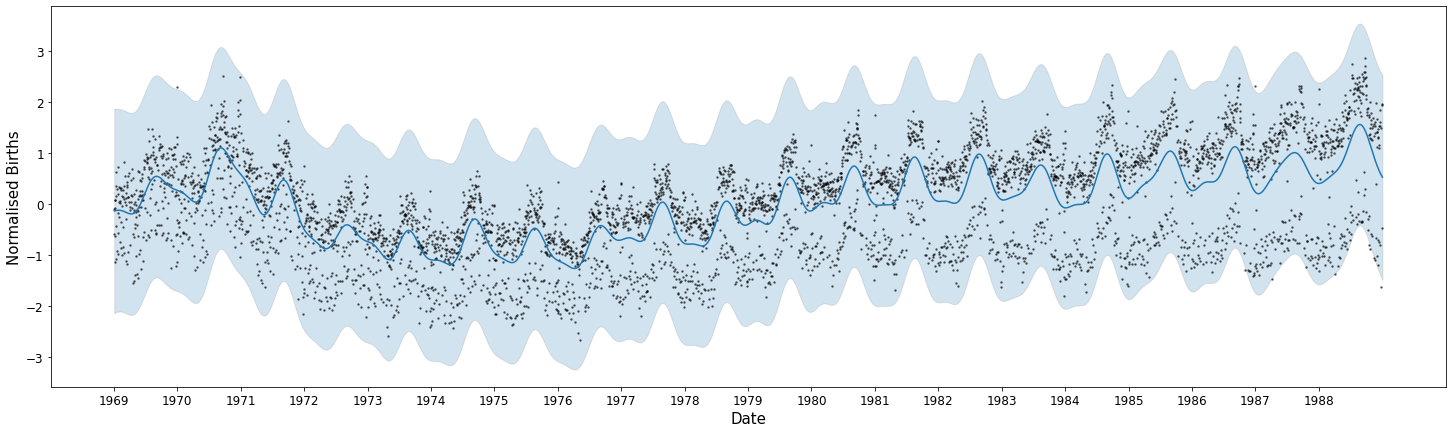

Test


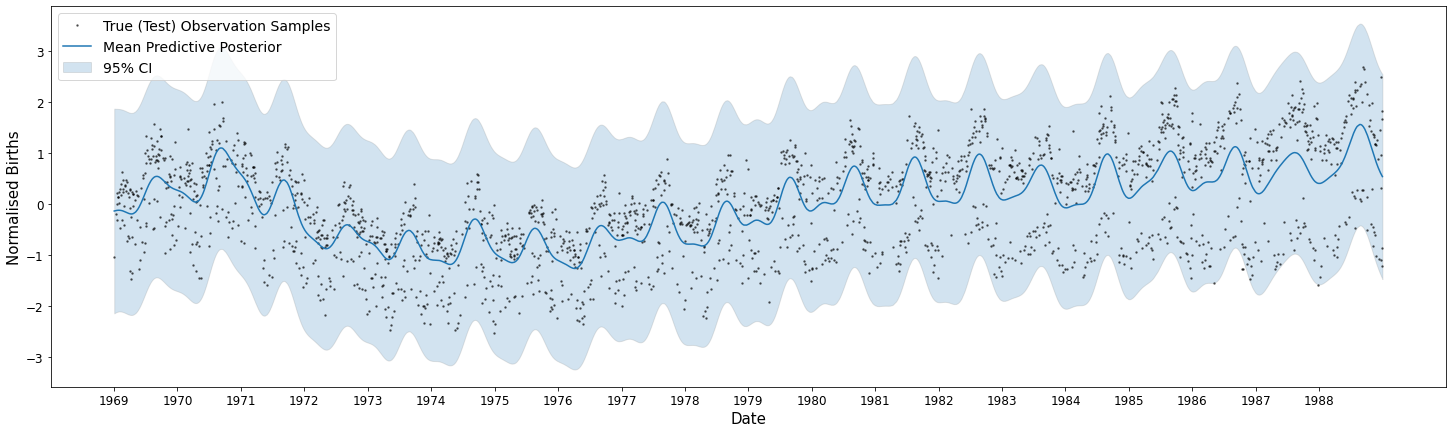

Log-marginal likelihood:  -6278.331085400552
train MSE, MAE:  0.5555810696213039 0.6273297961000441
test MSE, MAE:  0.5901797106668217 0.6465260610354374
Percentage of points that lie outside the CI: (train, test)  0.15646391550948563 0.18248175182481752
number of points that lie outside the CI: (train, test)  8 4
--------------------------------------------------------


In [5]:
# Kernel MODEL SELECTION
kernel_list = [gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25), gpflow.kernels.Periodic(gpflow.kernels.RBF()), gpflow.kernels.Matern32(), gpflow.kernels.RBF()]

for i in range(len(kernel_list)):
    print(kernel_list[i])

    kernel = kernel_list[i]

    model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)
    set_trainable(model.likelihood.variance , False)

    if i in [0, 1]:
        model.kernel.base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    else:
        model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    
    optimise_predict_model(model)
    print('--------------------------------------------------------')

The kernel with best performance: RBF. Although, Matern52 performs the same.

Now, we would carry out the sensitivity analysis done before but on the train test set.

Starting Values (l, v):  1 1
Train


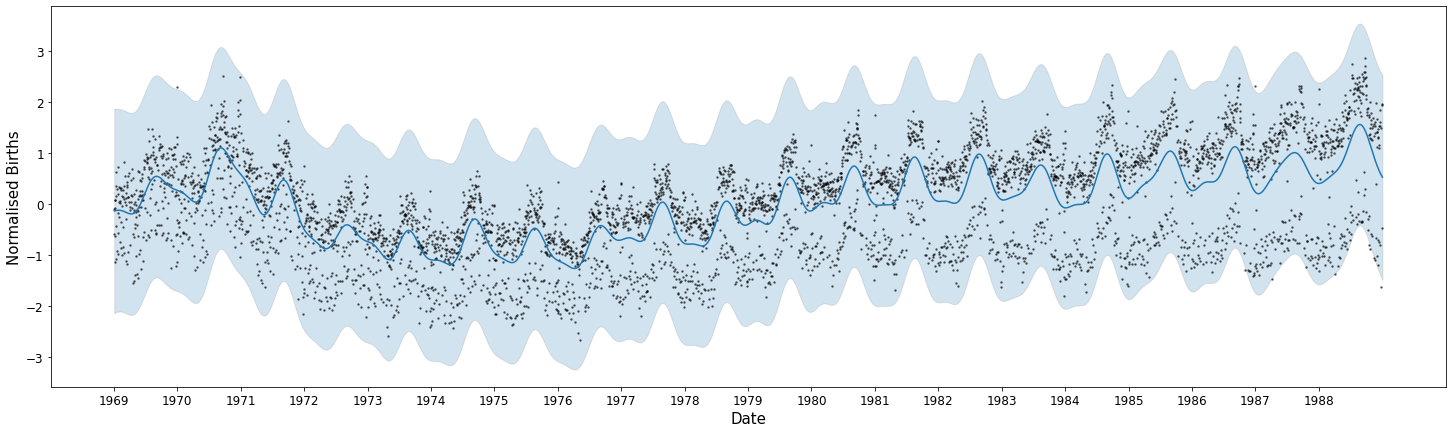

Test


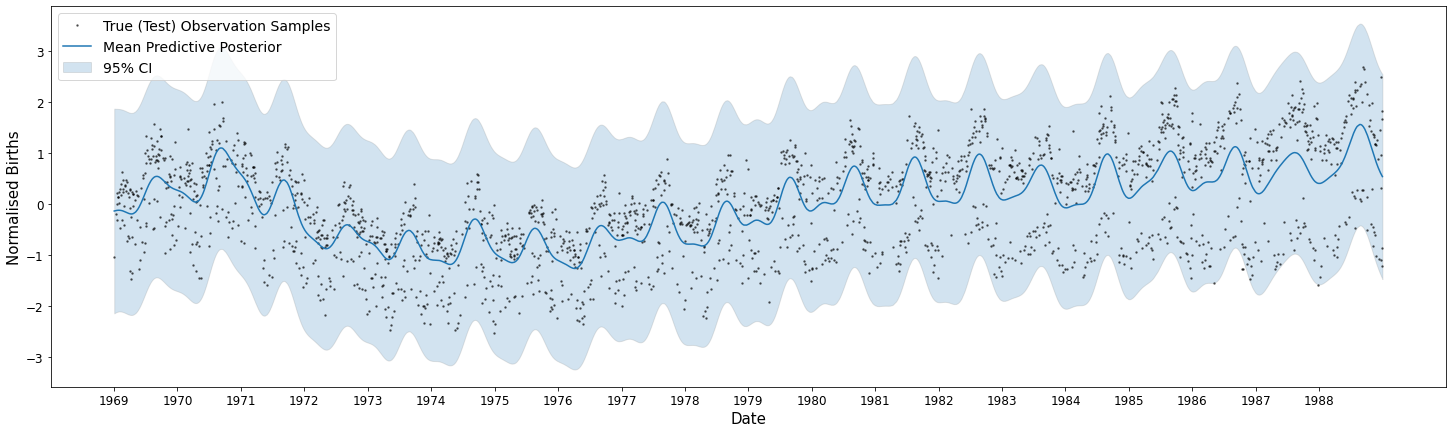

Log-marginal likelihood:  -6278.331085400552
train MSE, MAE:  0.5555810696213039 0.6273297961000441
test MSE, MAE:  0.5901797106668217 0.6465260610354374
Percentage of points that lie outside the CI: (train, test)  0.15646391550948563 0.18248175182481752
number of points that lie outside the CI: (train, test)  8 4
--------------------------------------------------------
Starting Values (l, v):  5 1
Train


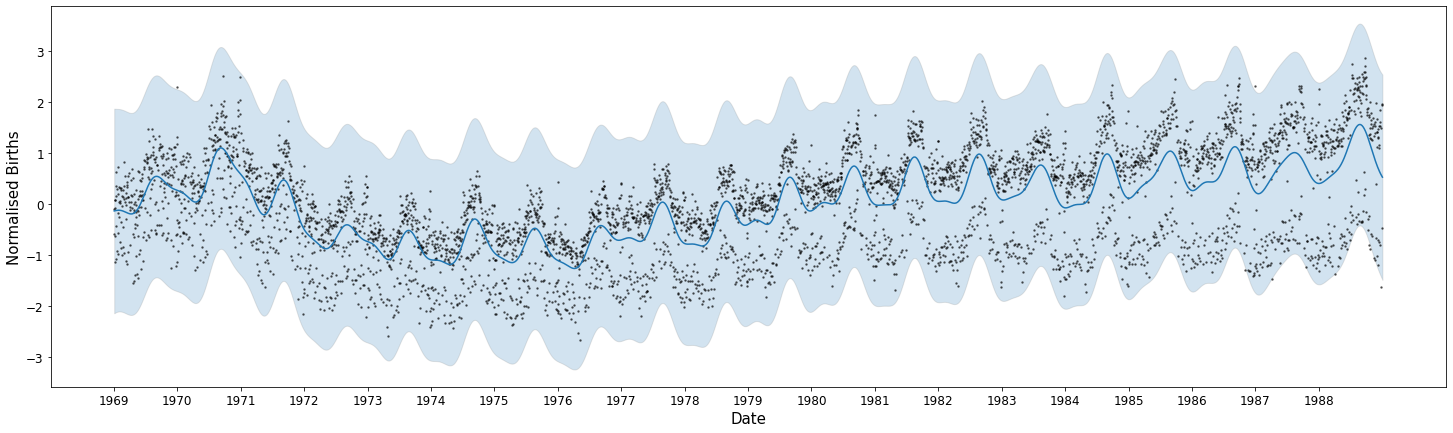

Test


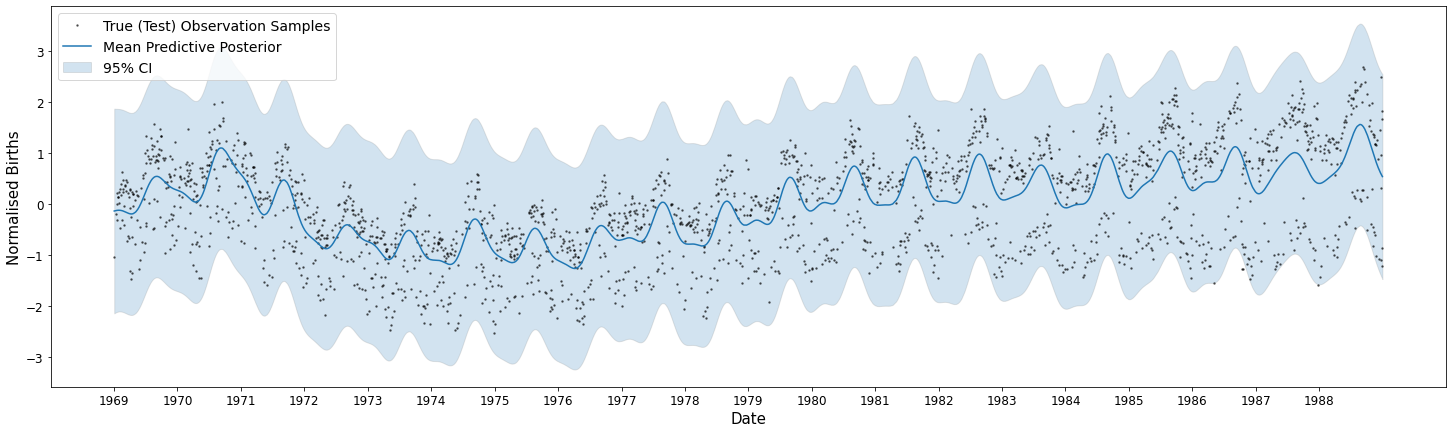

Log-marginal likelihood:  -6278.331006883922
train MSE, MAE:  0.5555814951602268 0.6273299449084603
test MSE, MAE:  0.5901803444857899 0.646526352454253
Percentage of points that lie outside the CI: (train, test)  0.15646391550948563 0.18248175182481752
number of points that lie outside the CI: (train, test)  8 4
--------------------------------------------------------


In [8]:
starting_values_l = [1, 5]
starting_values_v = [1]

for l in starting_values_l:
    for v in starting_values_v:
        print('Starting Values (l, v): ', l, v)
        kernel = gpflow.kernels.RBF(lengthscales = l, variance = v)
        model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)
        set_trainable(model.likelihood.variance , False)
        
        model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

        optimise_predict_model(model)
        print('--------------------------------------------------------')

There is no difference in the fit when using different starting conditions. 

Why is this the case in the train/test experiment but not so in the case where we work with the whole dataset ???

__________________________
__________________________

#### We have not been using a fully bayesian approach. This is because we have been using the marginal likelihood method for hyperparameter optimisation.
My guess is that even through we are setting the priors, they are not being used in the optimisation because of how optimisation works in the GPR model.
#### Let's now consider a full bayesian approach using VGP or SVGP --- NOTEBOOK: basic_VGP

_____________________________________
_____________________________________

Do the test/train split first first model, training the noise variance.

Train


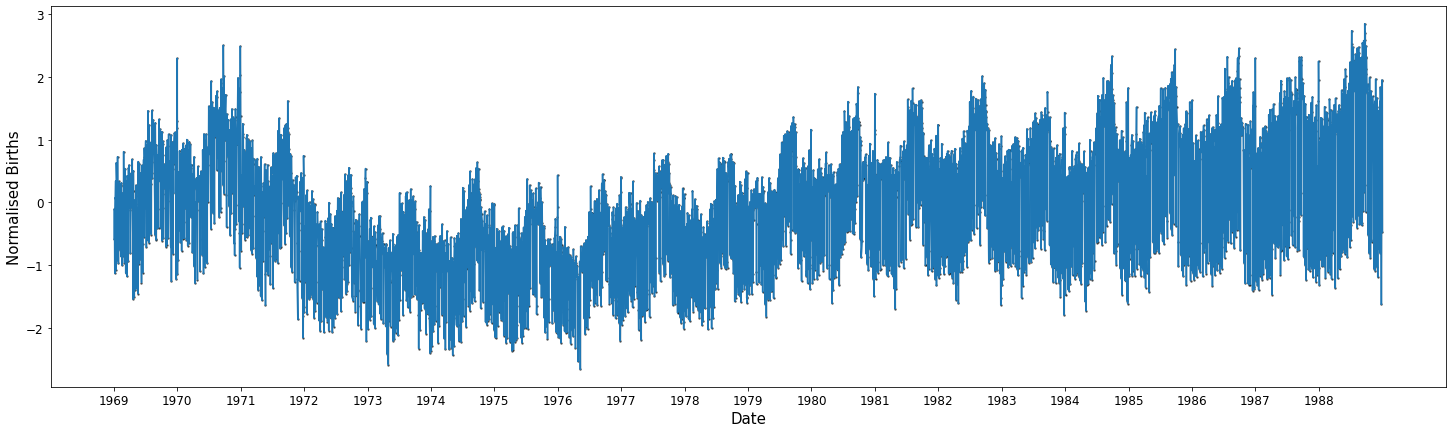

Test


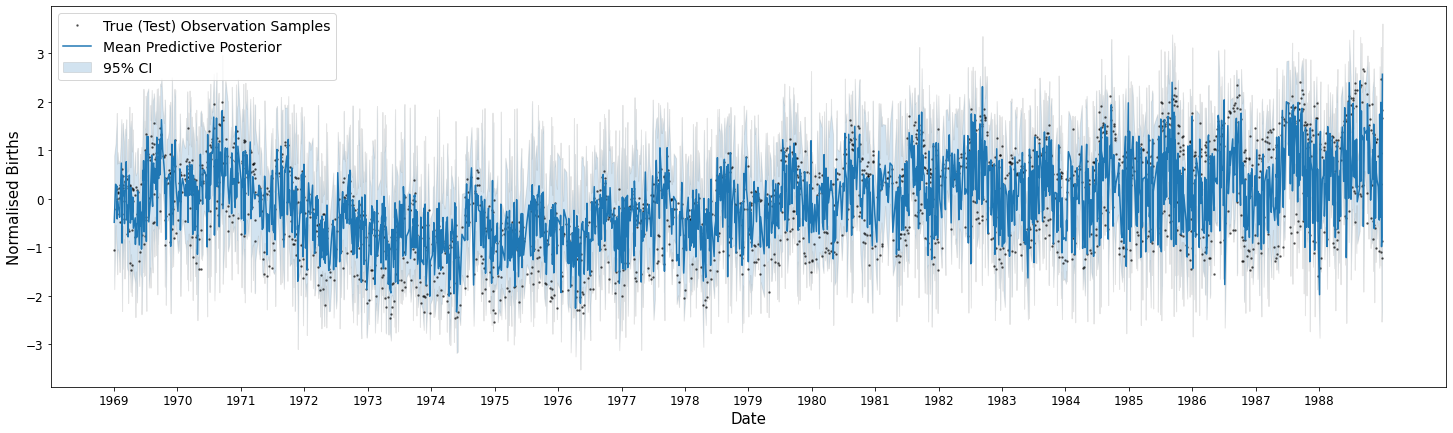

Log-marginal likelihood:  -6122.870802578261
train MSE, MAE:  4.848093105196113e-12 1.6979801622378203e-06
test MSE, MAE:  0.4547614762831527 0.526958513993085
Percentage of points that lie outside the CI: (train, test)  0.0 5.52007299270073
number of points that lie outside the CI: (train, test)  0 121


In [9]:
kernel = gpflow.kernels.RBF()

model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)

optimise_predict_model(model)


Now, without training the noise variance

Train


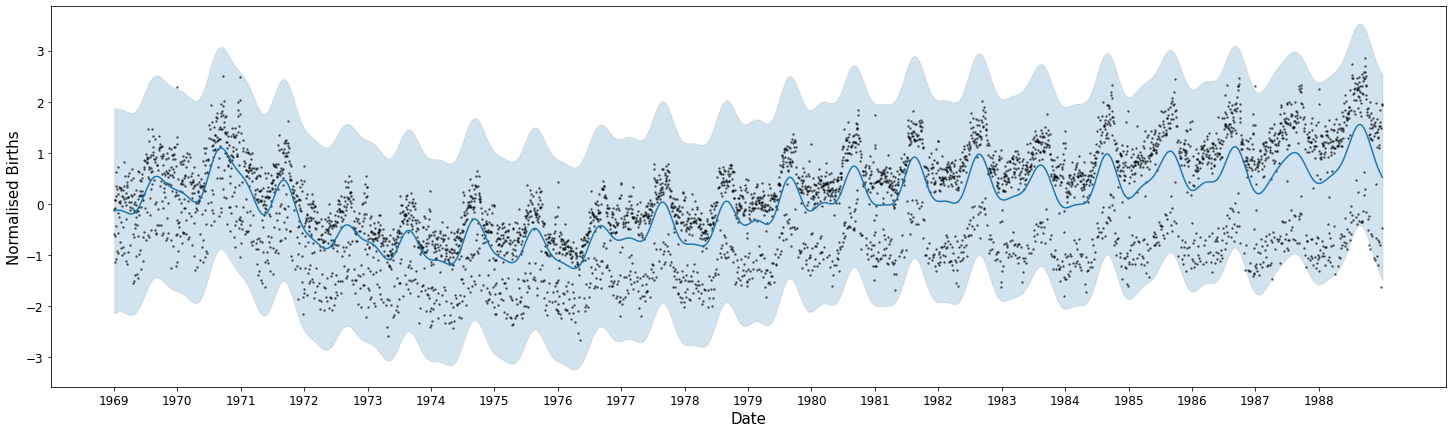

Test


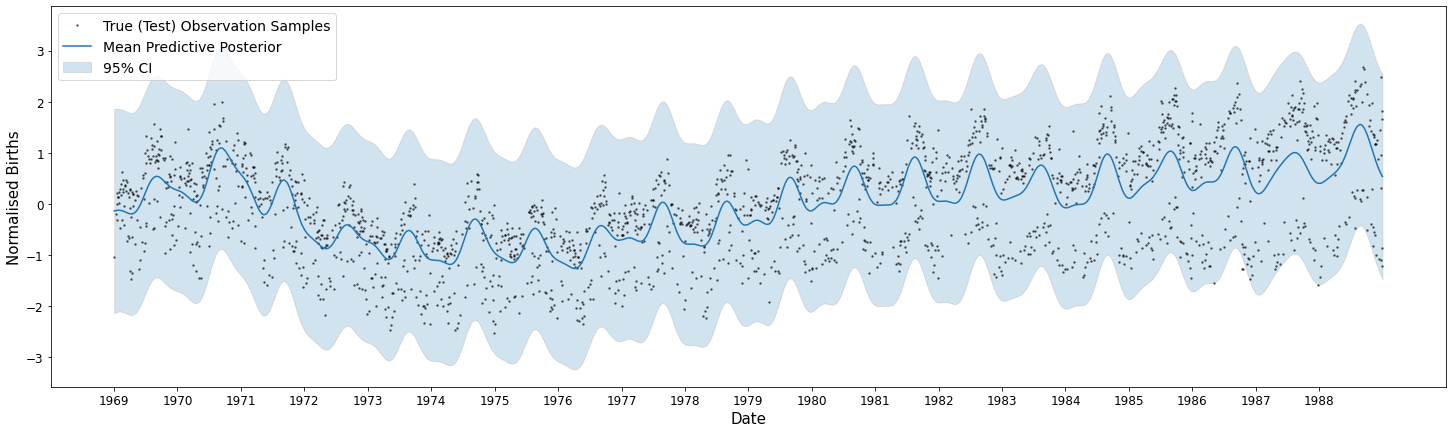

Log-marginal likelihood:  -6278.320242551773
train MSE, MAE:  0.5557035657533954 0.6273735978346654
test MSE, MAE:  0.5903615836171768 0.6466095087792045
Percentage of points that lie outside the CI: (train, test)  0.15646391550948563 0.18248175182481752
number of points that lie outside the CI: (train, test)  8 4


In [10]:
kernel = gpflow.kernels.RBF()

model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)

optimise_predict_model(model)

Train


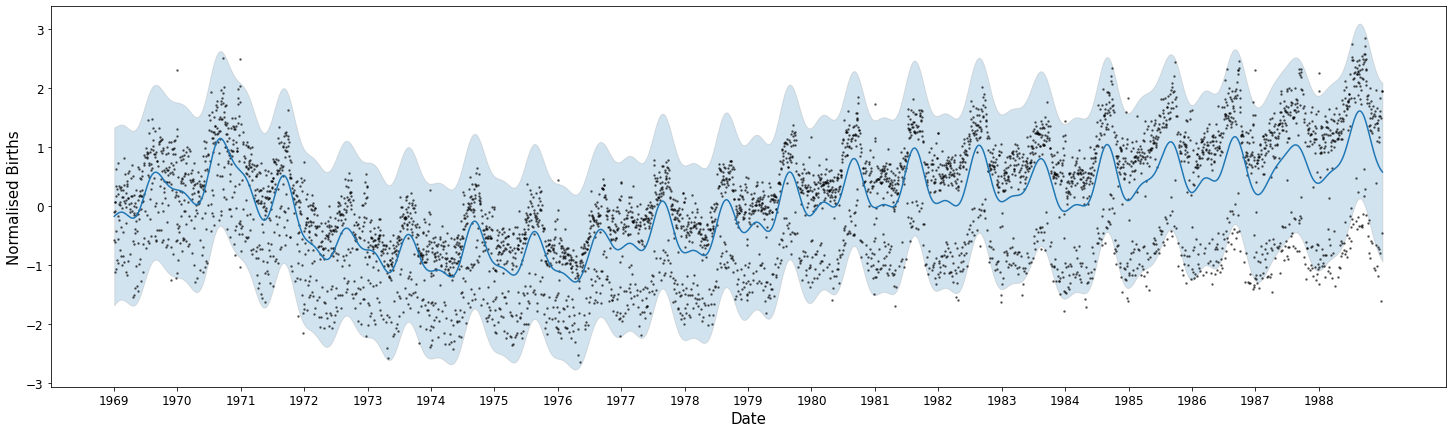

Test


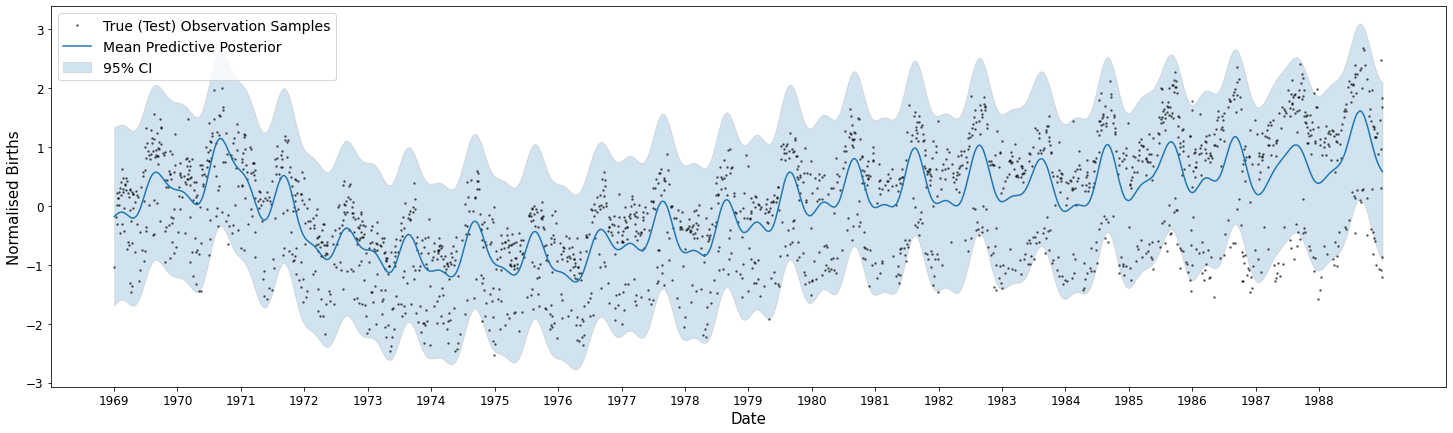

Log-marginal likelihood:  -5933.250298006228
train MSE, MAE:  0.552489325298093 0.6258802919052885
test MSE, MAE:  0.5863998099005976 0.6443701406925121
Percentage of points that lie outside the CI: (train, test)  3.207510267944455 3.64963503649635
number of points that lie outside the CI: (train, test)  164 80


: 

In [6]:
kernel = gpflow.kernels.RBF(lengthscales=77)

model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , True)

model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
    
optimise_predict_model(model)